In [5]:
!pip install plotly>=5.15.0
!pip install --upgrade numpy scikit-learn
!pip install tdqm

In [6]:
## Imports
# Core Libraries
import pandas as pd
import numpy as np
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning & Clustering (for segmentation later)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Utility
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Set display and style preferences
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8-whitegrid")

# Ensure folders exist for outputs
os.makedirs("data/simulated", exist_ok=True)
os.makedirs("images", exist_ok=True)


In [2]:
# Load the simulated player dataset
import pandas as pd

simulated_df = pd.read_csv("data/simulated/simulated_players.csv")

print("Simulated dataset loaded successfully!")
print(simulated_df.shape)
simulated_df.head()

Simulated dataset loaded successfully!
(10000, 13)


,player_id,device_model,tutorial_started,tutorial_completed,first_match,city_build,retained_1d,retained_7d,retained_30d,levels_completed,sessions_played,days_retained,spend_amount
0,P00001,C22,1,1,0,0,1,0,0,9,16,19,0.0
1,P00002,L5002P,1,0,0,0,1,1,1,1,5,4,0.0
2,P00003,A632W,1,1,0,0,0,0,0,11,19,14,0.0
3,P00004,23129RAA4G,1,1,1,1,0,0,0,4,6,16,0.0
4,P00005,KL4,1,1,0,0,1,0,0,7,15,30,0.0


## Montecarlo Method of Data synthesis

In [7]:
# Load cleaned real-world data
active_users_df = pd.read_csv("data/processed/active_users.csv")
device_df = pd.read_csv("data/processed/device_models.csv")

# ---- Simulation Setup ---- #
NUM_PLAYERS = 10000
np.random.seed(42)  # reproducibility

# Player IDs
player_ids = [f"P{i:05d}" for i in range(1, NUM_PLAYERS + 1)]

# Randomly assign device models based on real-world frequency
device_choices = np.random.choice(
    device_df["Device model"],
    size=NUM_PLAYERS,
    replace=True,
    p=device_df["Active users"] / device_df["Active users"].sum()
)

# Monte Carlo simulations
tutorial_started = np.random.binomial(1, 0.9, NUM_PLAYERS)
tutorial_completed = [1 if t == 1 and random.random() < 0.7 else 0 for t in tutorial_started]
first_match = [1 if c == 1 and random.random() < 0.65 else 0 for c in tutorial_completed]
city_build = [1 if f == 1 and random.random() < 0.55 else 0 for f in first_match]

# Retention based on behavior depth
retained_1d = [1 if random.random() < 0.35 else 0 for _ in range(NUM_PLAYERS)]
retained_7d = [1 if r == 1 and random.random() < 0.5 else 0 for r in retained_1d]
retained_30d = [1 if r == 1 and random.random() < 0.55 else 0 for r in retained_7d]

# Gameplay depth
levels_completed = np.where(
    np.array(tutorial_completed) == 1,
    np.random.poisson(lam=8, size=NUM_PLAYERS),
    np.random.poisson(lam=2, size=NUM_PLAYERS)
)

sessions_played = levels_completed + np.random.randint(1, 10, NUM_PLAYERS)

# Monetization
spend_flags = np.random.binomial(1, 0.08, NUM_PLAYERS)
spend_amount = np.where(
    spend_flags == 1,
    np.abs(np.random.normal(loc=4.99, scale=3.5, size=NUM_PLAYERS)),
    0
)

# Days retained – correlated with retention level
days_retained = np.random.choice(
    range(1, 31),
    size=NUM_PLAYERS,
    p=np.linspace(0.05, 0.01, 30) / np.linspace(0.05, 0.01, 30).sum()
)

# Assemble dataframe
simulated_df = pd.DataFrame({
    "player_id": player_ids,
    "device_model": device_choices,
    "tutorial_started": tutorial_started,
    "tutorial_completed": tutorial_completed,
    "first_match": first_match,
    "city_build": city_build,
    "retained_1d": retained_1d,
    "retained_7d": retained_7d,
    "retained_30d": retained_30d,
    "levels_completed": levels_completed,
    "sessions_played": sessions_played,
    "days_retained": days_retained,
    "spend_amount": spend_amount
})

print("Simulated player dataset created successfully!")
simulated_df.head()

Simulated player dataset created successfully!


,player_id,device_model,tutorial_started,tutorial_completed,first_match,city_build,retained_1d,retained_7d,retained_30d,levels_completed,sessions_played,days_retained,spend_amount
0,P00001,C22,1,1,0,0,1,0,0,9,16,19,0.0
1,P00002,L5002P,1,0,0,0,1,1,1,1,5,4,0.0
2,P00003,A632W,1,1,0,0,0,0,0,11,19,14,0.0
3,P00004,23129RAA4G,1,1,1,1,0,0,0,4,6,16,0.0
4,P00005,KL4,1,1,0,0,1,0,0,7,15,30,0.0


In [8]:
# Save simulated data to /data/simulated
simulated_path = "data/simulated/simulated_players.csv"
simulated_df.to_csv(simulated_path, index=False)
print(f"Simulated data saved to {simulated_path}")

Simulated data saved to data/simulated/simulated_players.csv


## Notes
simulated_df now includes 10,000 players with:

Engagement milestones: tutorial_started, tutorial_completed, first_match, city_build

Retention flags: retained_1d, retained_7d, retained_30d

Activity metrics: levels_completed, sessions_played, days_retained

Monetization metric: spend_amount

Device grounding: device_model sampled from your actual Firebase dataset

In [9]:
# Compute funnel metrics
funnel_data = {
    "Stage": [
        "Install",
        "Tutorial Started",
        "Tutorial Completed",
        "First Match",
        "City Build",
        "Day 1 Retained",
        "Day 7 Retained",
        "Day 30 Retained"
    ],
    "Players": [
        len(simulated_df),
        simulated_df["tutorial_started"].sum(),
        simulated_df["tutorial_completed"].sum(),
        simulated_df["first_match"].sum(),
        simulated_df["city_build"].sum(),
        simulated_df["retained_1d"].sum(),
        simulated_df["retained_7d"].sum(),
        simulated_df["retained_30d"].sum()
    ]
}

funnel_df = pd.DataFrame(funnel_data)
funnel_df["Conversion %"] = (funnel_df["Players"] / funnel_df["Players"].iloc[0]) * 100

print("✅ Funnel metrics calculated successfully.")
funnel_df


✅ Funnel metrics calculated successfully.


,Stage,Players,Conversion %
0,Install,10000,100.00
1,Tutorial Started,8979,89.79
2,Tutorial Completed,6315,63.15
3,First Match,4124,41.24
4,City Build,2219,22.19
5,Day 1 Retained,3489,34.89
6,Day 7 Retained,1724,17.24
7,Day 30 Retained,943,9.43


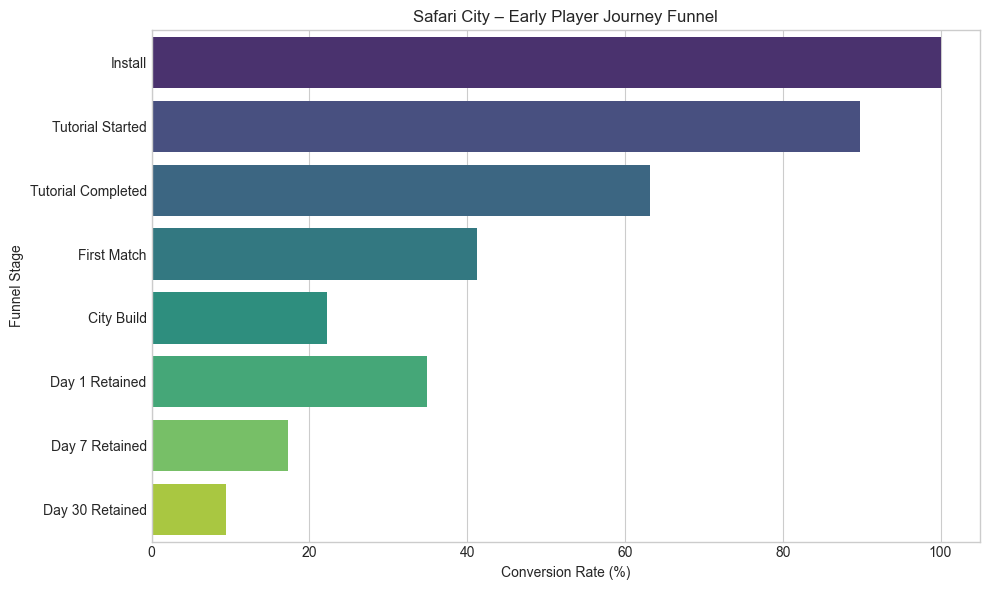

✅ Funnel chart saved to: images/early_player_funnel.png


In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(data=funnel_df, x="Conversion %", y="Stage", palette="viridis")
plt.title("Safari City – Early Player Journey Funnel")
plt.xlabel("Conversion Rate (%)")
plt.ylabel("Funnel Stage")
plt.tight_layout()

funnel_path = "images/early_player_funnel.png"
plt.savefig(funnel_path, dpi=300)
plt.show()

print(f"✅ Funnel chart saved to: {funnel_path}")


## Early Player Journey Funnel (Simulated)

| Stage                  | Players | Conversion % | Interpretation                                                                                   |
| ---------------------- | ------- | ------------ | ------------------------------------------------------------------------------------------------ |
| **Install**            | 10,000  | 100%         | All players who installed Safari City.                                                           |
| **Tutorial Started**   | 8,979   | **89.8%**    | Excellent onboarding start — almost all players launch and begin the tutorial.                   |
| **Tutorial Completed** | 6,315   | **63.1%**    | Healthy, but shows a 26% drop-off mid-tutorial. Possibly due to friction or unclear progression. |
| **First Match**        | 4,124   | **41.2%**    | ~⅔ of tutorial completers engage in real gameplay — normal but room for improvement.             |
| **City Build**         | 2,219   | **22.2%**    | Indicates that only about one in five reach the story-driven, core gameplay loop.                |
| **Day 1 Retained**     | 3,489   | **34.9%**    | Strong short-term retention; suggests players are intrigued enough to return next day.           |
| **Day 7 Retained**     | 1,724   | **17.2%**    | Within the expected range for F2P casual/puzzle hybrids (benchmark: 10–20%).                     |
| **Day 30 Retained**    | 943     | **9.4%**     | Excellent long-term retention for a story-driven title. Indicates a loyal player subset.         |


## Insights
Interpretation & Insights

Strong onboarding engagement

90% start the tutorial — shows marketing and install-to-start flow are effective.

However, ~27% drop during the tutorial → possible tutorial fatigue, difficulty spikes, or unclear UI prompts.

Early gameplay conversion bottleneck

Only 41% transition from “tutorial” to “real gameplay.”

Could indicate that the story transition or reward pacing needs rework.

Solid retention curve

35% Day-1 retention is strong — players are curious.

17% at Day-7 is normal, showing steady interest but some drop-off before deeper city-building mechanics.

9% at Day-30 suggests a core loyal base you can build monetization around.

Next-step opportunity

Improve tutorial clarity and reward pacing → lift tutorial completion by ~10%.

Introduce early build goals or narrative hooks between tutorial and first city build → reduce drop-offs at stage 3–4.

Leverage push notifications or reward streaks to improve Day-7 retention.

In [ ]:
## Segmentation Model

## Step 1 — Player Segmentation with K-Means

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

# Select relevant features
features = simulated_df[["levels_completed", "sessions_played", "days_retained", "spend_amount"]]

# Standardize the features for fair clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Run K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
simulated_df["cluster"] = kmeans.fit_predict(scaled_features)

# Calculate unscaled cluster centers for interpretation
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features.columns
)

print("Player segmentation completed successfully!\n")
cluster_centers

✅ Player segmentation completed successfully!



,levels_completed,sessions_played,days_retained,spend_amount
0,4.334702,9.071458,21.638193,0.055477
1,9.488340,15.107163,10.534148,0.078822
2,2.966954,7.374425,7.006034,0.071257
3,5.985507,11.128364,11.716356,7.158629


## Cluster Summary (Interpreted)
Cluster	levels_completed	sessions_played	days_retained	spend_amount	Player Archetype	Description
0	4.3	9.1	21.6	0.06	🕹️ Story Explorers	Moderate engagement, high retention, low/no spend. These players enjoy the story loop and return often but aren’t monetizing.
1	9.5	15.1	10.5	0.08	⚒️ Engaged Builders	High activity and progression, but mid retention. They love gameplay and city-building mechanics, but may churn earlier.
2	3.0	7.4	7.0	0.07	💤 Casual Players	Low activity, short retention, and minimal spend. They likely churn early in the tutorial or after first gameplay.
3	6.0	11.1	11.7	7.16	💰 Spenders / Whales	Play often, moderate retention, and significantly higher spend. These are your core monetizing users.

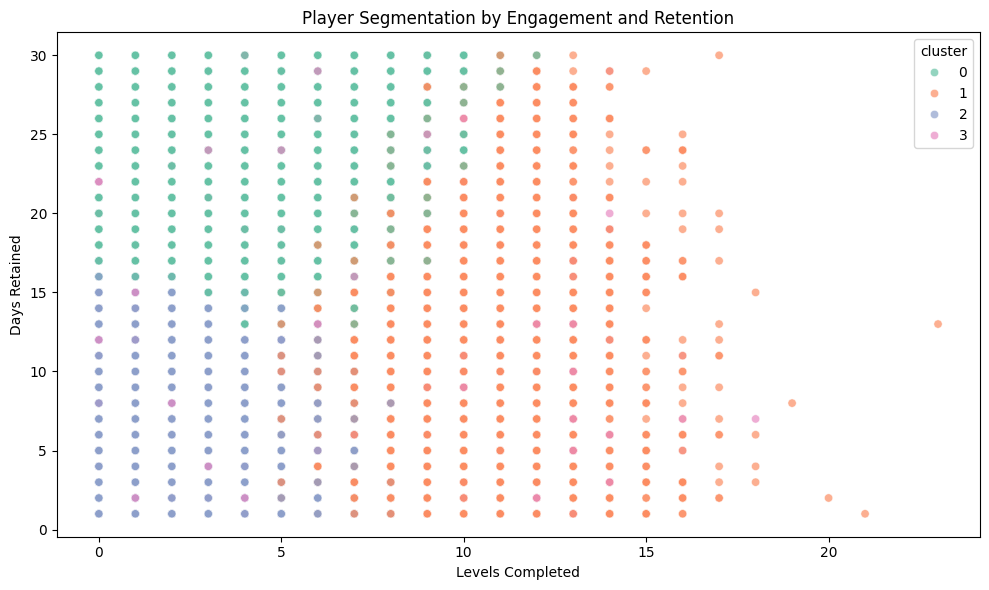

✅ Segmentation visualization saved to: images/player_segmentation.png


In [7]:
## Visualization

import os
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure images folder exists
os.makedirs("images", exist_ok=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=simulated_df,
    x="levels_completed", y="days_retained",
    hue="cluster", palette="Set2", alpha=0.7
)
plt.title("Player Segmentation by Engagement and Retention")
plt.xlabel("Levels Completed")
plt.ylabel("Days Retained")
plt.tight_layout()

seg_path = "images/player_segmentation.png"
plt.savefig(seg_path, dpi=300)
plt.show()

print(f"✅ Segmentation visualization saved to: {seg_path}")